In [33]:
import yaml  # type: ignore
import pandas as pd
import seaborn as sns
from matplotlib_venn import venn3
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
sns.set_style('darkgrid')

with open("../settings.yml", "r") as yamlfile:
    config = yaml.load(yamlfile, Loader=yaml.FullLoader)

# 

In [34]:
topics = pd.read_csv("../data/topics.csv", sep="\t", header=None, names=["topic_id", "topic_fr", "topic_en"])
topic_list = topics["topic_fr"].tolist()
topic_list.append("video")

queries_WT_train = pd.read_csv("../data/publish/French/Queries/train.tsv", sep="\t", header=None, names=["topic_id", "query"])
queries_WT_test = pd.read_csv("../data/publish/French/Queries/heldout.tsv", sep="\t", header=None, names=["topic_id", "query"])

queries_WT = pd.concat([queries_WT_train, queries_WT_test])
queries_ST = pd.read_csv("../data/test-collection/A-Short-July/French/Queries/test07.tsv", sep="\t", header=None, names=["topic_id", "query"])
queries_LT = pd.read_csv("../data/test-collection/B-Long-September/French/Queries/test09.tsv", sep="\t", header=None, names=["topic_id", "query"])


In [35]:
topic_bow = {}
for topic in topics.iterrows():
    t = topic[1]["topic_fr"]#.split(" ")
    #t.extend(topic[1]["topic_en"].split(" "))
    # if topic[1]["topic_en"] == "taxes":
    #     t.extend(["taxe"])

    topic_bow[topic[1]["topic_en"]] = t

topic_bow["video*"] = "video"  # add the topic video

In [36]:
def map_topic(row):
    assigned = []
    query = row["query"].lower()#.split()
    for topic, bow in topic_bow.items():
        if bow in query:
            assigned.append(topic)
        if "taxe" in query:
            assigned.append("taxes")
        # if "amber heard" in query:
        #     assigned.append("johnny depp")
       
    if len(assigned) > 0:
        return set(assigned)
    else: 
        assigned.append("other")
        return set(assigned)

In [37]:
queries_WT["topic"] = queries_WT.apply(map_topic, axis=1)
queries_ST["topic"] = queries_ST.apply(map_topic, axis=1)
queries_LT["topic"] = queries_LT.apply(map_topic, axis=1)

In [38]:
queries_WT[queries_WT["topic"]=={"water"}]

,topic_id,query,topic
1,q062228,aeroport bordeaux,{water}
6,q0622107,aquarelle et pinceaux,{water}
7,q0622117,arena bordeaux,{water}
12,q0622226,beaugrenelle,{water}
13,q0622232,beaune,{water}
...,...,...,...
75,q062219794,concert bordeaux,{water}
80,q062221273,pc bureau,{water}
82,q062221541,quiche aux poireaux,{water}
86,q062222425,bateaux,{water}


In [39]:
queries_ST[queries_ST["topic"] == {"other"}]

,topic_id,query,topic
5,q072287,amber heard,{other}


In [40]:
queries_LT[queries_LT["topic"] == {"other"}]

,topic_id,query,topic


In [41]:
queries_WT_grouped = queries_WT.explode("topic")["topic"].value_counts()
queries_ST_grouped = queries_ST.explode("topic")["topic"].value_counts()
queries_LT_grouped = queries_LT.explode("topic")["topic"].value_counts()

In [42]:
queries_by_topic = pd.merge(queries_WT_grouped, queries_ST_grouped, left_index=True, right_index=True, how="outer").merge(queries_LT_grouped, left_index=True, right_index=True, how="outer").fillna(0).rename(columns={"topic_x": "WT", "topic_y": "ST", "topic": "LT"})

In [43]:
queries_by_topic["total"] = queries_by_topic.sum(axis=1).astype(int)
queries_by_topic = queries_by_topic.sort_values(by="total", ascending=False)

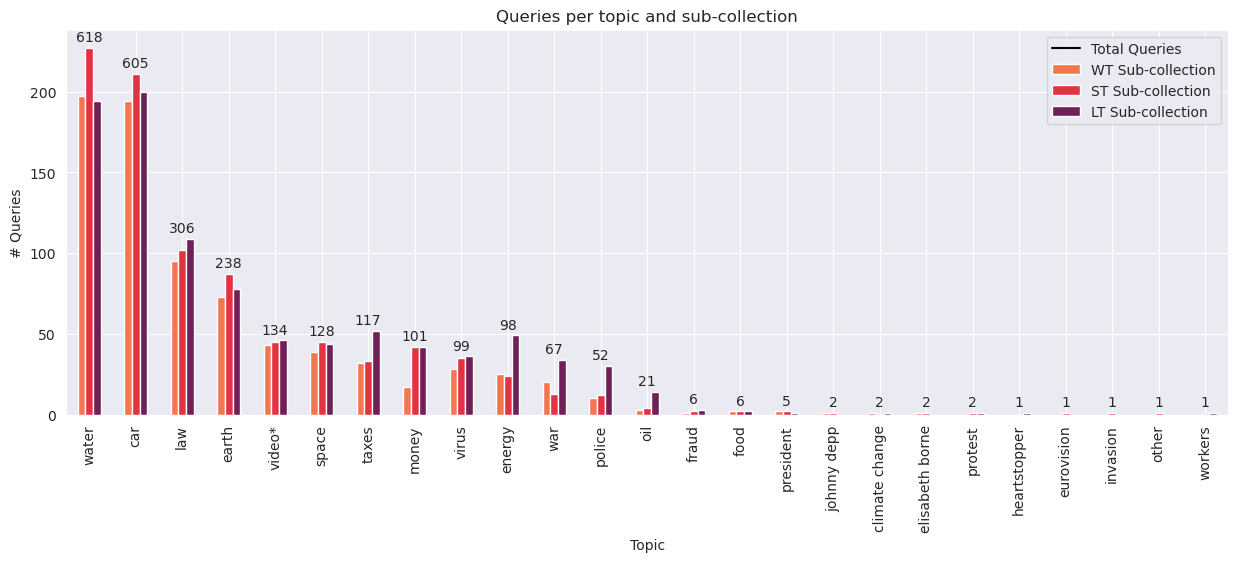

In [44]:
Palette = ["#f37651", "#e13342", "#701f57"] #define your preference
sns.set_palette(Palette)

ax = queries_by_topic[["WT", "ST", "LT"]].plot(
    kind="bar", 
    figsize=(15, 5), 
    title="Queries per topic and sub-collection",
    ylabel="# Queries",
    xlabel="Topic")

for WT, ST, LT in zip(ax.containers[0], ax.containers[1], ax.containers[2]):
    heights = [WT.get_height(), ST.get_height(), LT.get_height()]
    label = str(int(sum(heights)))

    y = max(heights) + 4
    # len(label)
    x = ST.get_x()+ST.get_width()/2.
    ax.annotate(label, (x, y), ha='center')
ln1 = ax.plot(0, 0, '', label='Location of the last 48h', color="black")

ax.legend(["Total Queries", "WT Sub-collection", "ST Sub-collection", "LT Sub-collection"])


# Queries

In [45]:
WT_test = pd.read_csv("../"+config["WT"]["test"]["topics"].replace("trec", "tsv"), sep="\t", names=["qid", "query"])
WT_train = pd.read_csv("../"+config["WT"]["train"]["topics"].replace("trec", "tsv"), sep="\t", names=["qid", "query"])

ST = pd.read_csv("../"+config["ST"]["test"]["topics"].replace("trec", "tsv"), sep="\t", names=["qid", "query"])
LT = pd.read_csv("../"+config["LT"]["test"]["topics"].replace("trec", "tsv"), sep="\t", names=["qid", "query"])

In [46]:
WT_test["len"] = WT_test["query"].apply(lambda x: len(x.split(" ")))
WT_train["len"] = WT_train["query"].apply(lambda x: len(x.split(" ")))
WT = pd.concat([WT_train, WT_test])

LT["len"] = LT["query"].apply(lambda x: len(x.split(" ")))
ST["len"] = ST["query"].apply(lambda x: len(x.split(" ")))

In [47]:
WT[WT["len"]>100]

,qid,query,len
399,q062213307,leg leg leg leg leg leg leg leg leg leg leg le...,108


In [48]:
ST[ST["len"]>100]

,qid,query,len
170,q072211861,leg leg leg leg leg leg leg leg leg leg leg le...,110


In [49]:
total = pd.DataFrame({
    "Name": ["WT", "ST", "LT"],
    "Train": [len(WT_train), 0, 0],
    "Test": [len(WT_test), len(ST), len(LT)],
    "Total": [sum([len(WT_train), len(WT_test)]), len(ST), len(LT)]
    })
total

,Name,Train,Test,Total
0,WT,672,98,770
1,ST,0,882,882
2,LT,0,923,923


Text(0.5, 1.0, 'Number of Topics per type in the Subcollections')

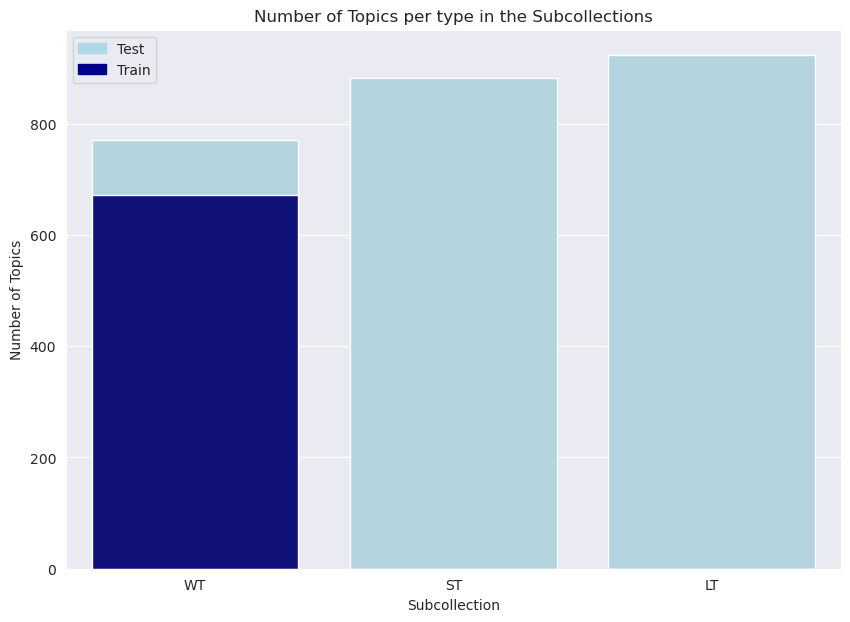

In [50]:
plt.figure(figsize=(10, 7))

bar1 = sns.barplot(x="Name",  y="Total", data=total, color='lightblue')
bar2 = sns.barplot(x="Name",  y="Train", data=total, estimator=sum, errorbar=None, color='darkblue')

top_bar = mpatches.Patch(color='lightblue', label='Test')
bottom_bar = mpatches.Patch(color='darkblue', label='Train')
plt.legend(handles=[top_bar, bottom_bar])

bar2.set_ylabel("Number of Topics")
bar2.set_xlabel("Subcollection")
bar2.set_title("Number of Topics per type in the Subcollections")


# Topic intersections per subcollection

In [51]:
WT = pd.concat([WT_train, WT_test])

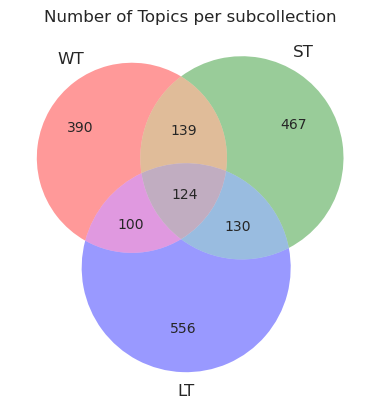

In [52]:
set1 = set(WT["query"].to_list())
set2 = set(ST["query"].to_list())
set3 = set(LT["query"].to_list())

venn3([set1, set2, set3], ('WT', 'ST', 'LT'))

plt.title("Number of Topics per subcollection")
plt.show()

In [53]:
print("Number of topics in WT: ", len(set1))
print("Number of topics in ST: ", len(set2))
print("Number of topics in LT: ", len(set3))

Number of topics in WT:  753
Number of topics in ST:  860
Number of topics in LT:  910


In [54]:
intersection = set1 & set2 & set3
len(intersection)

124

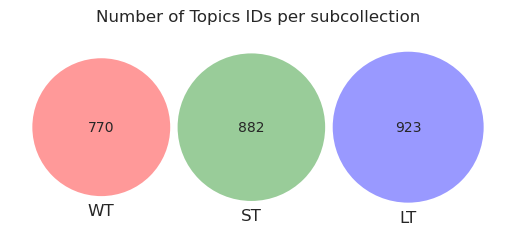

In [55]:
set1 = set(WT["qid"].to_list())
set2 = set(ST["qid"].to_list())
set3 = set(LT["qid"].to_list())

venn3([set1, set2, set3], ('WT', 'ST', 'LT'))

plt.title("Number of Topics IDs per subcollection")
plt.show()

# Core Queries

In [56]:
tfs = WT.merge(ST, on="query", how="outer", suffixes=("_WT", "_ST")).merge(LT, on="query", how="outer").rename(columns={"tf": "tf_LT"})

In [71]:
core_queries[["qid_WT", "qid_ST", "qid_LT"]]

,qid_WT,qid_ST,qid_LT
0,q06224934,q072217124,q092226099
1,q062219244,q072222669,q092219185
2,q062221837,q072225856,q092227648
3,q06221714,q072228375,q09222467
4,q06223196,q072215005,q092223595
...,...,...,...
168,q06229356,q07223464,q092232439
172,q062215941,q072214883,q09224505
176,q062222032,q072226086,q092223271
177,q062210914,q07225346,q092212311


In [57]:
core_queries = WT.set_index("query").merge(ST.set_index("query"), left_index=True, right_index=True, how="outer", suffixes=("_WT", "_ST")).merge(LT.set_index("query"),left_index=True, right_index=True, how="outer").dropna()

core_queries = core_queries[["qid_WT", "qid_ST", "qid"]].reset_index().drop_duplicates("query").rename({"qid": "qid_LT"}, axis=1)

In [58]:
core_queries.to_csv("../data/core_queries.tsv", sep="\t", header=True)

# Duduplicate queries

In [59]:
WT[WT["query"].duplicated(keep=False)].sort_values(by="query")

,qid,query,len
246,q06227960,Corsican car rental,3
425,q062214358,Corsican car rental,3
80,q062221273,Office,1
306,q06229698,Office,1
655,q062224463,Potatoes,1
352,q062211672,Potatoes,1
28,q06227021,anti-virus,1
484,q062216105,anti-virus,1
174,q062215093,barbecued potatoes,2
528,q062218247,barbecued potatoes,2


In [60]:
tfs.set_index("query", inplace=True)

In [61]:
len(WT_test["query"].unique())

97

In [62]:
WT_train[WT_train["query"].duplicated(keep=False)].sort_values(by="query")

,qid,query,len
246,q06227960,Corsican car rental,3
425,q062214358,Corsican car rental,3
655,q062224463,Potatoes,1
352,q062211672,Potatoes,1
174,q062215093,barbecued potatoes,2
528,q062218247,barbecued potatoes,2
56,q06221716,cheap car rental,3
582,q062220782,cheap car rental,3
533,q062218344,elderberry,1
279,q06228988,elderberry,1


In [63]:
a = tfs.dropna().drop_duplicates()

In [64]:
a[a.index.duplicated()]

,qid_WT,len_WT,qid_ST,len_ST,qid,len
query,,,,,,
oil prices,q062224542,2.0,q07228073,2.0,q092217941,2.0
electric car rental,q062217639,3.0,q07221901,3.0,q092223429,3.0
mashed potatoes,q06225642,2.0,q072218020,2.0,q092223550,2.0
used car,q06229333,2.0,q07229512,2.0,q092210109,2.0
used car,q06229333,2.0,q07229512,2.0,q092230973,2.0
used car,q06229333,2.0,q072230046,2.0,q09224481,2.0
used car,q06229333,2.0,q072230046,2.0,q092210109,2.0
used car,q06229333,2.0,q072230046,2.0,q092230973,2.0
used car,q06228353,2.0,q07229512,2.0,q09224481,2.0
